<a href="https://colab.research.google.com/github/vipulSharma18/Automatic-Emotion-Recognition-on-DEAP-Dataset/blob/main/models/Participant_Dependent_LSTM_on_DEAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
inp_choice = input("Enter b for Binary, m for Multi-Class Classification: ")

Enter b for Binary, m for Multi-Class Classification: b


# Add Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Relevant Libraries

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Softmax

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
import pickle
import gc
from keras.callbacks import ReduceLROnPlateau
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
%matplotlib inline

In [5]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# GPU Check

In [6]:
print(tf.version.VERSION)
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1
[]
Num GPUs Available:  0


# Data Augmentation

## Load Data from .dat files into a np array of 32 x 40 x 32 x 8064 size

In [7]:
all_sub_data = []
subjects_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
for sub in subjects_list:
    path = "/content/drive/MyDrive/major project/data_preprocessed_python/s"+sub+".dat"
    x = pickle.load(open(path, 'rb'), encoding = 'latin1')
    sub_data = x['data']
    sub_eeg = sub_data[:, :32, :]  #indexing EEG signals from physiological data
    all_sub_data.append(sub_eeg)
    gc.collect()
gc.collect()
all_sub_data = np.array(all_sub_data)


In [8]:
all_sub_data.shape
#32 participants, 40 videos, 32 channels, 8064 EEG length

(32, 40, 32, 8064)

## Label Loading into np array of (32,40) named, sub_labels

In [9]:
if(inp_choice == 'm'):
  labels = pd.read_excel("/content/drive/MyDrive/major project/metadata/Labels.xls")
  #for multiclass classification 
  sub_labels = labels["Valence-Arousal Model Quadrant"].astype('int')
  gc.collect()
  sub_labels


In [10]:
if(inp_choice == 'b'):
  labels = pd.read_excel("/content/drive/MyDrive/major project/metadata/Labels.xls")
  #for binary classification of valence scale
  sub_labels = labels["Valence Label (1=H, 0=L)"].astype('int')
  gc.collect()
  sub_labels


###For creating subject_wise labels

In [11]:
temp = []
for i in range(0,32):
  temp.append(sub_labels[40*i:40*(i+1)])
sub_labels = np.array(temp.copy())
del temp
gc.collect()
print(sub_labels.shape)

(32, 40)


## Label Binarization of multi-class labels  
> return value:
 sub_labels: (32,40,4)  
  The Subject wise binarized multi-class weights  
 multi_class_weights: (32,4)  
  The subject wise mutli class weights 

In [12]:
#computation of class weights, subject_wise
if(inp_choice == 'm'):
  mutli_class_weights = []
  for i in range(32):
    labels = sub_labels[i]
    multi_weights = compute_class_weights("balanced", classes = [0,1,2,3], y=labels)
    print(multi_weights, 'for participant', i+1)
    multi_class_weights.append(dict(enumerate(multi_weights)))
  multi_class_weights = np.array(d_multi_class_weights)
  print(multi_class_weights)

In [13]:
if(inp_choice == 'm'):
  temp = []
  for i in range(32):
    labels = sub_labels[i]
    lb = preprocessing.LabelBinarizer()
    labels = lb.fit_transform(labels)
    print(lb.classes_, 'for participant', i+1)
    temp.append(labels)
  sub_labels = np.array(temp.copy())
  del temp
  gc.collect()
  print(sub_labels.shape)
  print(sub_labels)

In [14]:
gc.collect()

152

In [15]:
if(inp_choice == 'm'):
  np.unique(sub_labels[0], axis = 0)

## Label Binarization of 2/Binary labels  
> return_val: sub_labels: (32,40,2)  
  bin_class_weights: (32, 2)  The binary weights for each subject's labels

In [16]:
sub_labels.shape

(32, 40)

In [17]:
if(inp_choice == 'b'):
  bin_class_weights = []
  for i in range(32):
    labels = sub_labels[i]
    bin_weights = compute_class_weight("balanced", classes = [0,1], y=labels)
    print(bin_weights, 'for participant', i+1)
    bin_class_weights.append(dict(enumerate(bin_weights)))
  bin_class_weights = np.array(bin_class_weights)
  print(bin_class_weights)

[0.95238095 1.05263158] for participant 1
[1.33333333 0.8       ] for participant 2
[1.11111111 0.90909091] for participant 3
[0.83333333 1.25      ] for participant 4
[1.25       0.83333333] for participant 5
[2.         0.66666667] for participant 6
[1.66666667 0.71428571] for participant 7
[1.11111111 0.90909091] for participant 8
[1.05263158 0.95238095] for participant 9
[1. 1.] for participant 10
[1.25       0.83333333] for participant 11
[1.05263158 0.95238095] for participant 12
[0.90909091 1.11111111] for participant 13
[1. 1.] for participant 14
[1. 1.] for participant 15
[0.8        1.33333333] for participant 16
[1.11111111 0.90909091] for participant 17
[1.42857143 0.76923077] for participant 18
[1.17647059 0.86956522] for participant 19
[1.17647059 0.86956522] for participant 20
[1.05263158 0.95238095] for participant 21
[1. 1.] for participant 22
[1.53846154 0.74074074] for participant 23
[0.95238095 1.05263158] for participant 24
[1.05263158 0.95238095] for participant 2

In [18]:
def encode(x):
  if(x==1):
    return [0,1]
  elif(x==0):
    return [1,0]
  else:
    print("invalid value")
    return None

In [19]:
if(inp_choice == 'b'):
  sub_labels_bin = []
  for i in range(32):
    labels = sub_labels[i]
    sub_labels_bin.append(np.array(list(map(encode, labels))))
  sub_labels = np.array(sub_labels_bin.copy())
  del sub_labels_bin
  gc.collect()
  print(sub_labels.shape)

(32, 40, 2)


In [20]:
def inv_bin(x):
  if(x == [0,1]):
     return 1
  elif(x==[1,0]):
    return 0


## Repetition of Labels for Windowing of training data  



In [21]:
#12 signals of each length 672 generated from 8064 length signal
upper_temp = []
for i in range(32):
  labels = np.array(sub_labels[i])
  temp = np.repeat(labels, 12, axis = 0)
  upper_temp.append(temp)
sub_labels = np.array(upper_temp.copy())
del upper_temp
gc.collect()
print(sub_labels.shape)
#should be 32, 480, 2/4



(32, 480, 2)


In [22]:
print(sub_labels[0])

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

## Loading Training data with different window sizes

input of shape all_sub_data (32, 40, 32, 8064)

In [23]:
temp = []
for i in range(32):
  sub_data = all_sub_data[i]
  sub_temp = []
  for vid in range(40):
    vid_data = np.array(sub_data[vid]).T.copy()
    assert (vid_data.shape == (8064,32)), "The transpose didn't work"
    vid_data = np.vsplit(vid_data, 12)
    sub_temp.extend(vid_data)
  temp.append(sub_temp)
all_sub_data = np.array(temp.copy())
del temp
gc.collect()
print(all_sub_data.shape)
#should be (32, 480, 672, 32)

(32, 480, 672, 32)


## Generating Train Test Splits  


In [24]:
X_train_subs, X_test_subs, y_train_subs, y_test_subs = [], [], [], []
for i in range(32):
  labels = sub_labels[i]
  sub_data = all_sub_data[i]
  X_train, X_test, y_train, y_test = train_test_split(sub_data, labels, test_size = 0.25, random_state = 42,shuffle = True, stratify = labels)
  X_train_subs.append(X_train)
  X_test_subs.append(X_test)
  y_train_subs.append(y_train)
  y_test_subs.append(y_test)
X_train_subs, X_test_subs, y_train_subs, y_test_subs = list(map(np.array, [X_train_subs, X_test_subs, y_train_subs, y_test_subs]))
print(X_train_subs.shape, y_train_subs.shape, X_test_subs.shape, y_test_subs.shape)


(32, 360, 672, 32) (32, 360, 2) (32, 120, 672, 32) (32, 120, 2)


In [25]:
try:
  del all_sub_data
  del sub_labels
  del labels
  del sub_data
  del temp
  del vid_data
  del x
  del sub_eeg
except:
  print("Freed")
gc.collect()

Freed


200

# Models Fitting and Evaluation

## Helper Functions for plotting, confusion matrix etc.

In [26]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    plt.show() 

In [27]:
def plot_evaluation_curves(history, EPOCHS, plt_mtrc):
  epochs_range = range(EPOCHS)
  fig, axs = plt.subplots(len(plt_mtrc), figsize = (8,28))
  for pos,mtrc in enumerate(plt_mtrc):
    metric = history.history[mtrc]
    #val_metric = history.history[mtrc[1]]
    axs[pos].plot(epochs_range, metric, label='Training ' + mtrc)
    #axs[pos].plot(epochs_range, val_metric, label='Validation '+ mtrc[0])
    axs[pos].legend(loc='lower right')
    axs[pos].set_title('Training ' +  mtrc)
  plt.show()


In [28]:
def show_metrics(x, y, model):
  pred_y = model.predict(x)
  c_pred = Counter(np.argmax(pred_y, axis = 1))
  print(c_pred, "Predicted Distribution:")
  c_true = Counter(np.argmax(y, axis = 1))
  print(c_true, "Actual Distribution:")
  print("Measures of Model:",model.evaluate(x, y))
  print("Classification Report of Model on Data:")
  print(classification_report(np.argmax(y, axis =1), np.argmax(model.predict(x), axis = 1) , digits = 4) )
  make_confusion_matrix(confusion_matrix(np.argmax(y, axis = 1), np.argmax(model.predict(x), axis = 1)))
  print("\n------------------------------------------------------------------------------------------\n")
  gc.collect()

## Model Architecture Function

In [29]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

In [30]:
def dummy_model(sub_signals=12, metrics = METRICS):
  sample_size = int(8064/sub_signals)
  model = Sequential()
  model.add(Dense(80, activation = 'relu', input_shape = (sample_size, 32)))
  model.add(Flatten())
  model.add(Dense(30, activation = 'relu'))
  try:
    #fc2 and softmax
    if (inp_choice == 'b'):
      #binary classification
      model.add(Dense(2,  activation = 'softmax'))
      model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4) , loss = tf.keras.losses.BinaryCrossentropy(), metrics= metrics)
    elif (inp_choice == 'm'):
      #mutliclass classification
      model.add(Dense(4, activation = 'softmax'))
      model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= metrics)
  except ValueError:
    raise ValueError("ValueError exception thrown. Invalid Classfication choice, No Model was Created")
  print("Dummy Model defined.")
  return model

In [31]:
def create_model(sub_signals=12, metrics = METRICS):
  n_steps = int(8064/sub_signals)
  model = Sequential()
  model.add(LSTM(64, activation='relu', input_shape=(n_steps,32), return_sequences=True))
  model.add(Dropout(rate = 0.2, seed = RANDOM_SEED))
  model.add(LSTM(32, activation='sigmoid'))
  try:
    #fc2 and softmax
    if (inp_choice == 'b'):
      #binary classification
      model.add(Dense(2,  activation = 'softmax'))
      model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = tf.keras.losses.BinaryCrossentropy(), metrics= metrics)
    elif (inp_choice == 'm'):
      #mutliclass classification
      model.add(Dense(4, activation = 'softmax'))
      model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= metrics)
  except ValueError:
    raise ValueError("ValueError exception thrown. Invalid Classfication choice, No Model was Created")
  print("LSTM Model defined.")
  return model

# Training

### Without Any modifications to deal with Class Imbalance (Vanilla)

In [32]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

Variables already freed


88

Baseline Model

Enter number of subjects to test for: 1
For subject ID  1
Dummy Model defined.
Training Data: 
Counter({0: 184, 1: 176}) Predicted Distribution:
Counter({0: 189, 1: 171}) Actual Distribution:
12/12 [==============================] - 0s 10ms/step - loss: 0.3724 - accuracy: 0.9861 - auc: 0.9932
Measures of Model: [0.37244537472724915, 0.9861111044883728, 0.9932098388671875]
Classification Report of Model on Data:
              precision    recall  f1-score   support

           0     1.0000    0.9735    0.9866       189
           1     0.9716    1.0000    0.9856       171

    accuracy                         0.9861       360
   macro avg     0.9858    0.9868    0.9861       360
weighted avg     0.9865    0.9861    0.9861       360



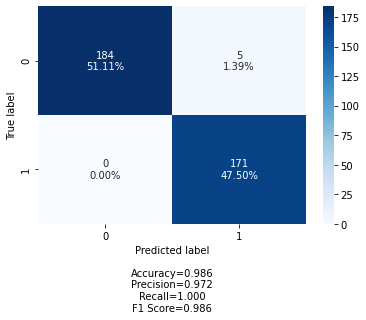


------------------------------------------------------------------------------------------

Testing Data: 
Counter({0: 110, 1: 10}) Predicted Distribution:
Counter({0: 63, 1: 57}) Actual Distribution:
4/4 [==============================] - 0s 9ms/step - loss: 0.8673 - accuracy: 0.5583 - auc: 0.5584
Measures of Model: [0.8672730326652527, 0.5583333373069763, 0.5583680272102356]
Classification Report of Model on Data:
              precision    recall  f1-score   support

           0     0.5455    0.9524    0.6936        63
           1     0.7000    0.1228    0.2090        57

    accuracy                         0.5583       120
   macro avg     0.6227    0.5376    0.4513       120
weighted avg     0.6189    0.5583    0.4634       120



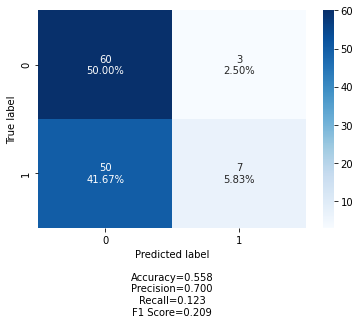


------------------------------------------------------------------------------------------



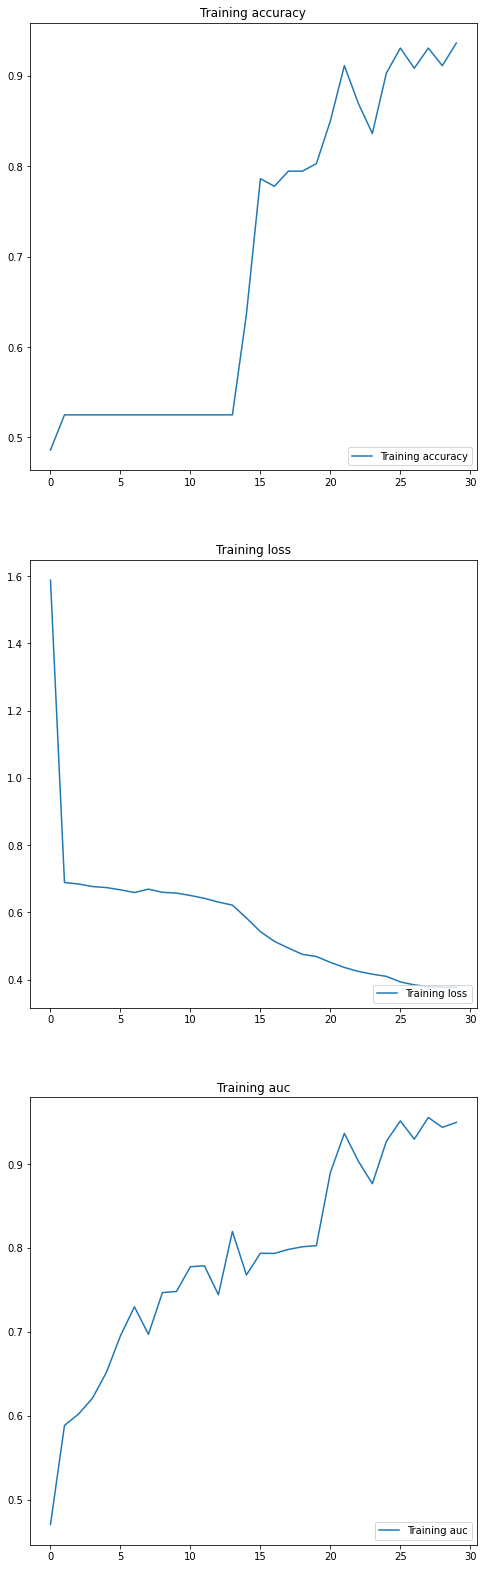

In [33]:
models = [0]*32
instances = int(input("Enter number of subjects to test for: "))
for sub in range(instances):
  print("For subject ID ", sub+1)
  X_train, X_test, y_train, y_test = X_train_subs[sub], X_test_subs[sub], y_train_subs[sub], y_test_subs[sub]
  baseline_model = dummy_model(sub_signals = 12, metrics = METRICS)
  epochs = 30   
  history = baseline_model.fit(X_train, y_train, epochs = epochs, shuffle = True, verbose = 0)
  print("Training Data: ")
  show_metrics(X_train, y_train, baseline_model)
  print("Testing Data: ")
  show_metrics(X_test, y_test, baseline_model)
  plot_metrics = ['accuracy', 'loss', 'auc']
  plot_evaluation_curves(history, epochs, plot_metrics)
  print("\n===========================================================================")
  #baseline_model.save("/content/drive/MyDrive/major project/LSTM Models/Vanilla Models/bin_12_baseline")
  gc.collect()


In [43]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

977

LSTM Model

In [44]:
models = [0]*32
instances = int(input("Enter number of subjects to test for: "))
for sub in range(instances):
  print("For subject ID ", sub+1)
  X_train, X_test, y_train, y_test = X_train_subs[sub], X_test_subs[sub], y_train_subs[sub], y_test_subs[sub]
  model = create_model(sub_signals = 12, metrics = METRICS)
  epochs = 30
  history= model.fit(X_train, y_train, epochs = epochs, shuffle = True, verbose = 3)
  print("Training Data: ")
  show_metrics(X_train, y_train, model)
  print("Testing Data: ")
  show_metrics(X_test, y_test, model)
  plot_metrics = ['accuracy', 'loss', 'auc']
  plot_evaluation_curves(history, epochs, plot_metrics)
  print("\n===========================================================================")
  #model.save("/content/drive/MyDrive/major project/LSTM Models/Vanilla Models/bin_12_1DCNN")
  gc.collect()



Enter number of subjects to test for: 2
For subject ID  1
LSTM Model defined.
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30


InvalidArgumentError: ignored

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 672, 64)           24832     
_________________________________________________________________
dropout (Dropout)            (None, 672, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 37,314
Trainable params: 37,314
Non-trainable params: 0
_________________________________________________________________


### With Class Weights set

In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

Input Dependent Baseline Model

In [ ]:
baseline_model = dummy_model(sub_signals = 12, metrics = METRICS)
epochs = 100
x_train, x_val, y_train, y_val = train_test_split( X_train_12 ,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)

#Input Dependent dummy model
if(inp_choice == 'b'):
  weights = d_bin_class_weights
else:
  weights = d_multi_class_weights 
history= baseline_model.fit(x_train, y_train, batch_size = 256, epochs = epochs, \
                                    validation_data = (x_val, y_val),  class_weight = weights, shuffle = True, verbose = 0)

show_metrics(x_train, x_val, y_train, y_val, baseline_model)
show_test_metrics(x_test_12, y_test_12, baseline_model)
plot_metrics = [('accuracy','val_accuracy'), ('precision', 'val_precision'), ('recall', 'val_recall'), ('auc', 'val_auc'), ('loss', 'val_loss')]
plot_evaluation_curves(history, epochs, plot_metrics)
baseline_model.save("/content/drive/MyDrive/major project/LSTM Models/Model with Class Weights/bin_12_baseline")
gc.collect()



In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

Input Independent LSTM model

In [ ]:
model = create_model(sub_signals = 12, metrics = METRICS)
epochs = 100
if(inp_choice == 'b'):
  weights = d_bin_class_weights
else:
  weights = d_multi_class_weights 
x_train, x_val, y_train, y_val = train_test_split( null_data,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
history= model.fit(x_train, y_train, batch_size = 256, epochs = epochs, \
                            validation_data = (x_val, y_val),  class_weight = weights, shuffle = True, verbose = 0)

show_metrics(x_train, x_val, y_train, y_val, model)
show_test_metrics(x_test_12, y_test_12, model)
plot_metrics = [('accuracy','val_accuracy'), ('precision', 'val_precision'), ('recall', 'val_recall'), ('auc', 'val_auc'), ('loss', 'val_loss')]
plot_evaluation_curves(history, epochs, plot_metrics)
model.save("/content/drive/MyDrive/major project/LSTM Models/Model with Class Weights/bin_12_null_1DCNN")
gc.collect()


In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

LSTM Input Dependent

In [ ]:
model = create_model(sub_signals = 12, metrics = METRICS)
epochs = 100
if(inp_choice == 'b'):
  weights = d_bin_class_weights
else:
  weights = d_multi_class_weights 
x_train, x_val, y_train, y_val = train_test_split( X_train_12,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
history= model.fit(x_train, y_train, batch_size = 256, epochs = epochs, \
                            validation_data = (x_val, y_val),  class_weight = weights, shuffle = True, verbose = 0)

show_metrics(x_train, x_val, y_train, y_val, model)
show_test_metrics(x_test_12, y_test_12, model)
plot_metrics = [('accuracy','val_accuracy'), ('precision', 'val_precision'), ('recall', 'val_recall'), ('auc', 'val_auc'), ('loss', 'val_loss')]
plot_evaluation_curves(history, epochs, plot_metrics)
model.save("/content/drive/MyDrive/major project/LSTM Models/Model with Class Weights/bin_12_1DCNN")
gc.collect()


### With Resampling Done using SMOTE

In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

Input Dependent Baseline Model

In [ ]:
baseline_model = dummy_model(sub_signals = 12, metrics = METRICS)
epochs = 100
x_train, x_val, y_train, y_val = train_test_split( X_train_12,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
#reshaping for smote
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
y_train = np.argmax(y_train, axis = 1)
x_train, y_train = SMOTE(random_state=RANDOM_SEED).fit_resample(x_train,y_train)
print("Resampled Using SMOTE.")
y_train = np.array(list(map(encode, y_train)))
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
#Input Dependent dummy model
history = baseline_model.fit(x_train, y_train, batch_size = 256, epochs = epochs, \
                                    validation_data = (x_val, y_val), shuffle = True, verbose = 0)
show_metrics(x_train, x_val, y_train, y_val, baseline_model)
show_test_metrics(x_test_12, y_test_12, baseline_model)
plot_metrics = [('accuracy','val_accuracy'), ('precision', 'val_precision'), ('recall', 'val_recall'), ('auc', 'val_auc'), ('loss', 'val_loss')]
plot_evaluation_curves(history, epochs, plot_metrics)
baseline_model.save("/content/drive/MyDrive/major project/LSTM Models/Model with SMOTE/bin_12_baseline")
gc.collect()


In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

Input Independent LSTM model

In [ ]:
model = create_model( sub_signals = 12, metrics = METRICS)
epochs = 100

#Null Data generation
x_train, x_val, y_train, y_val = train_test_split( null_data,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
y_train = np.argmax(y_train, axis = 1)
x_train, y_train = SMOTE(random_state=RANDOM_SEED).fit_resample(x_train,y_train)
print("Resampled Using SMOTE.")
y_train = np.array(list(map(encode, y_train)))
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

history= model.fit(x_train, y_train, batch_size = 256, epochs = epochs, \
                             validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
show_metrics(x_train, x_val, y_train, y_val, model)
show_test_metrics(x_test_12, y_test_12, model)
plot_metrics = [('accuracy','val_accuracy'), ('precision', 'val_precision'), ('recall', 'val_recall'), ('auc', 'val_auc'), ('loss', 'val_loss')]
plot_evaluation_curves(history, epochs, plot_metrics)
model.save("/content/drive/MyDrive/major project/LSTM Models/Model with SMOTE/bin_12_null_1DCNN")
gc.collect()


In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del model
  del history
except:
  print("Variables already freed")
gc.collect()

LSTM Input Dependent

In [ ]:
model = create_model( sub_signals = 12, metrics = METRICS)
epochs = 100
x_train, x_val, y_train, y_val = train_test_split( X_train_12,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
y_train = np.argmax(y_train, axis = 1)
x_train, y_train = SMOTE(random_state=RANDOM_SEED).fit_resample(x_train,y_train)
print("Resampled Using SMOTE.")
y_train = np.array(list(map(encode, y_train)))
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
#Actual Model Training with real data
history = model.fit(x_train, y_train, batch_size = 256, \
                            epochs = epochs, validation_data = (x_val, y_val), shuffle = True, verbose = 0)
show_metrics(x_train, x_val, y_train, y_val, model)
show_test_metrics(x_test_12, y_test_12, model)
plot_metrics = [('accuracy','val_accuracy'), ('precision', 'val_precision'), ('recall', 'val_recall'), ('auc', 'val_auc'), ('loss', 'val_loss')]
plot_evaluation_curves(history, epochs, plot_metrics)
model.save("/content/drive/MyDrive/major project/LSTM Models/Model with SMOTE/bin_12_1DCNN")
gc.collect()

